####  Intro: Mapping Child Mortality 
##### Absolute numbers of deaths in 2013-2018 , WHO data (not mortality rates, hence bad for comparative infornation)
\*[R code for the pictures below](https://github.com/madinajapakhova/Project-replication-/blob/master/R%20visuals/who.R)\*


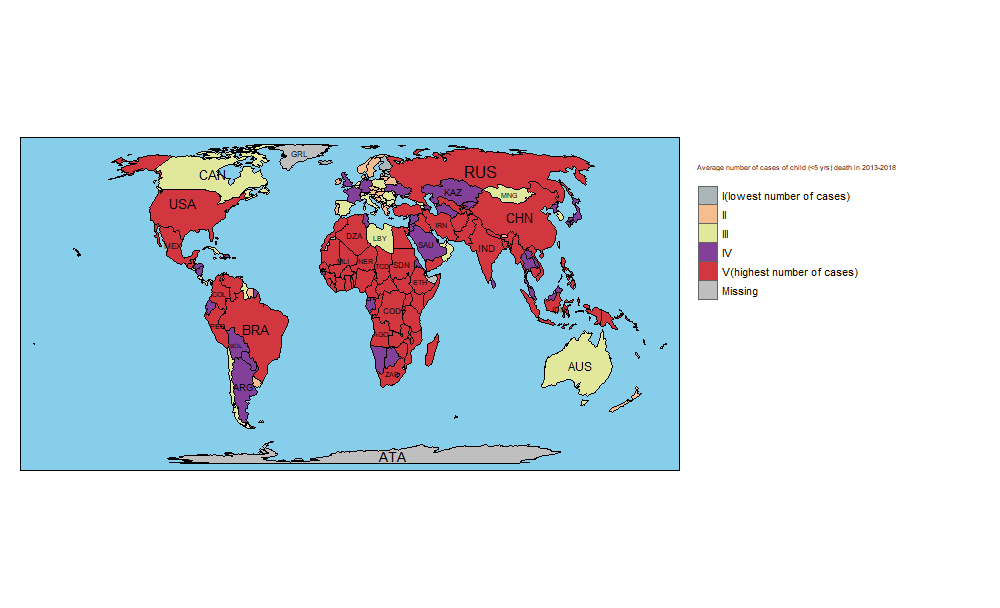

In [6]:
from IPython.display import Image
Image(filename='World.png') 
#change the map, for 2011-2013, mortality rate comparison. WHO  data

In [7]:
print("Country of interest: Uganda")

Country of interest: Uganda


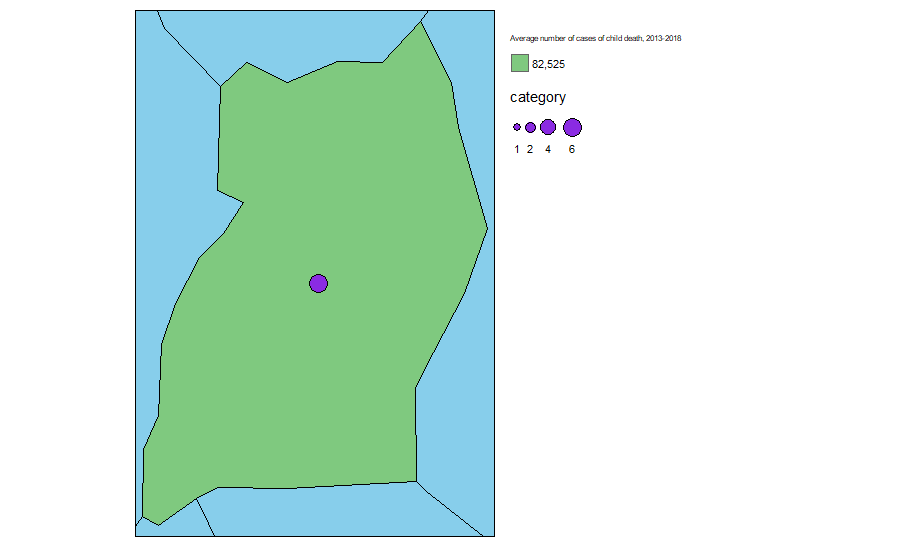

In [8]:
Image(filename='Rplot01.png')

In [16]:
import numpy as np
import pandas as pd
import scipy as sp
from linearmodels import PanelOLS
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
import statsmodels.regression.linear_model as sm 

Assignment procedure: a randomized trial (simple randomization). To see whether the randomization is well-balanced, we compare the means of the subjects' pretrial covariates: 

In [73]:
baseline = pd.read_csv("AEJ2018_HHmain.csv")
baseline.index.set_names("Household", inplace = True)
baseline.head()

,district,branchid,villageid,treatment,village_hhs_baseline,village_hhsu5_baseline,village_hhs_endline,village_share_immigrants,village_distance_road,village_distance_electricity,...,HH_meals,HH_electricity,HH_TV,HH_radio,HH_floor_material,HH_floor_material_oth,HH_roof_material,HH_roof_material_oth,HH_distanceVHT,HH_distanceCHP
Household,,,,,,,,,,,,,,,,,,,,,
0,10,41,1003,0,116,68,110,0.105263,6.00096,4.264567,...,2.0,0,0,1,1,NaN,1,NaN,0.072225,0.379127
1,10,41,1003,0,116,68,110,0.105263,6.00096,4.264567,...,2.0,0,0,0,1,NaN,1,NaN,0.054040,0.361292
2,10,41,1003,0,116,68,110,0.105263,6.00096,4.264567,...,4.0,0,0,1,1,NaN,1,NaN,0.029849,0.345872
3,10,41,1003,0,116,68,110,0.105263,6.00096,4.264567,...,3.0,0,0,1,6,NaN,2,NaN,0.050989,0.368697
4,10,41,1003,0,116,68,110,0.105263,6.00096,4.264567,...,0.0,0,0,0,1,NaN,1,NaN,0.058294,0.345088


In [74]:
baseline.columns

Index(['district', 'branchid', 'villageid', 'treatment',
       'village_hhs_baseline', 'village_hhsu5_baseline', 'village_hhs_endline',
       'village_share_immigrants', 'village_distance_road',
       'village_distance_electricity', 'village_distance_HOSP',
       'village_distance_HF', 'village_HF_within5km', 'hhid',
       'HH_knowledge_nutrients', 'HH_knowledge_nets',
       'HH_knowledge_zinchelpful', 'HH_knowledge_zincdisease',
       'HH_knowledge_zincdisease_oth', 'HH_knowledge_zincdisease_1',
       'HH_knowledge_zincdisease_2', 'HH_knowledge_zincdisease_3',
       'HH_knowledge_zincdisease_4', 'HH_knowledge_diarrheazinc',
       'HH_knowledge_malaria_1', 'HH_knowledge_malaria_2',
       'HH_knowledge_malaria_3', 'HH_knowledge_malaria_4',
       'HH_knowledge_malaria_onlymosq', 'HH_bheavior_treatwater',
       'HH_knowledge_untreatedw', 'HH_knowledge_untreatedw_d',
       'HH_knowledge_untreatedw_d_oth', 'HH_knowledge_untreatedw_d_1',
       'HH_knowledge_untreatedw_d_2', 'H

In [90]:
baseline = baseline.groupby(["treatment", "villageid", "branchid"])[["village_hhs_baseline", "village_hhsu5_baseline",
"village_distance_road", "village_distance_electricity", "village_distance_HF", "village_HF_within5km",
"village_distance_HOSP"]].mean()
summary_statistics = baseline.groupby("treatment").mean()
summary_statistics.columns = ["Households per cluster", "Households with under-5 children per cluster",
                              "Distance to main road", "Distance to electricity translission line",
                             "Distance to health center", "Number of health centers within 5 km",
                             "Distance to hospital"]
summary_statistics = summary_statistics.reset_index()
summary_statistics = summary_statistics.round(decimals=1)
print(summary_statistics)

   treatment  Households per cluster  \
0          0                   221.1   
1          1                   249.8   

   Households with under-5 children per cluster  Distance to main road  \
0                                          78.0                    6.8   
1                                          86.5                    5.6   

   Distance to electricity translission line  Distance to health center  \
0                                        1.8                        1.7   
1                                        1.8                        1.4   

   Number of health centers within 5 km  Distance to hospital  
0                                   7.3                  11.1  
1                                   8.3                  10.4  


In [94]:
df = pd.read_stata("AEJ2018_child_mortality.dta") 
df.count()
df = df[df.datedeath_cmc<1333]
df.count()

branchid              221
villageid             221
treatment             221
hhid                  221
childID               221
female                221
datebirth_m           221
datebirth_yr          221
datebirth_cmc         221
died                  221
datedeath_m           221
datedeath_yr          221
datedeath_cmc         221
aad                   221
dateofinterview_m     221
dateofinterview_yr    221
dtype: int64

In [95]:
df['death_u5'] = np.where((df['died']==1) & (df['aad']<60), 1, 0) 
df['death_u1'] = np.where((df['died']==1) & (df['aad']<12), 1, 0)
df['death_u1m'] = np.where((df['died'] == 1) & (df['aad']<1), 1,0)

In [96]:
df = df.groupby(['branchid', 'villageid', 'treatment'], as_index = False)[['death_u5', 
'death_u1','death_u1m']].sum().reset_index()
df.count() #in Stata collapse (sum) reduces # of obs from 11342 to 214, here after groupby only 123 obs left (?) 

death_u5     123
death_u1     123
death_u1m    123
dtype: int64

In [70]:
df.describe()

,branchid,villageid,treatment,hhid,childID,female,datebirth_m,datebirth_yr,datebirth_cmc,died,datedeath_m,datedeath_yr,datedeath_cmc,aad,dateofinterview_m,dateofinterview_yr,death_u5,death_u1,death_u1m
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.00000,123.000000,123.000000,123.000000
mean,15.707317,1414.886179,0.512195,252806.040650,2.000000,0.764228,13.056911,3609.869873,2365.642334,1.796748,13.504066,3610.325195,2371.552734,5.910569,17.894308,3616.85376,1.796748,1.601626,0.975610
std,14.987827,238.781957,0.501896,146474.818855,1.361051,0.769088,9.427289,2073.143555,1357.780273,1.031943,9.693140,2073.362061,1360.626465,7.986681,10.371629,2077.30249,1.031943,1.022211,0.909543
min,1.000000,1001.000000,0.000000,100115.000000,1.000000,0.000000,1.000000,2008.000000,1304.000000,1.000000,1.000000,2008.000000,1304.000000,0.000000,9.000000,2013.00000,1.000000,0.000000,0.000000
25%,5.000000,1306.500000,0.000000,141278.000000,1.000000,0.000000,7.000000,2009.000000,1316.000000,1.000000,7.500000,2009.000000,1320.000000,0.000000,10.000000,2013.00000,1.000000,1.000000,0.000000
50%,5.000000,1347.000000,1.000000,202269.000000,2.000000,1.000000,11.000000,4016.000000,2611.000000,2.000000,11.000000,4016.000000,2616.000000,2.000000,18.000000,4026.00000,2.000000,1.000000,1.000000
75%,31.000000,1629.000000,1.000000,327338.500000,2.000000,1.000000,17.000000,4019.000000,2645.500000,2.000000,16.500000,4020.000000,2653.500000,9.000000,20.000000,4026.00000,2.000000,2.000000,1.500000
max,42.000000,1906.000000,1.000000,811137.000000,8.000000,3.000000,66.000000,12054.000000,7914.000000,6.000000,66.000000,12055.000000,7926.000000,39.000000,66.000000,12078.00000,6.000000,6.000000,4.000000


In [99]:
print(df.columns)
df = df.set_index(['branchid','villageid'])

Index(['index', 'branchid', 'villageid', 'treatment', 'death_u5', 'death_u1',
       'death_u1m'],
      dtype='object')


In [100]:
from linearmodels import PanelOLS
model = PanelOLS(df['death_u5'],df['treatment'], entity_effects = True)
res = model.fit(cov_type='robust', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:               death_u5   R-squared:                        0.0014
Estimator:                   PanelOLS   R-squared (Between):             -0.0442
No. Observations:                 123   R-squared (Within):               0.0014
Date:                Mon, May 04 2020   R-squared (Overall):             -0.0341
Time:                        21:15:42   Log-likelihood                   -171.98
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.1583
Entities:                          12   P-value                           0.6915
Avg Obs:                       10.250   Distribution:                   F(1,110)
Min Obs:                       3.0000                                           
Max Obs:                       37.000   F-statistic (robust):             0.1716
                            

In [101]:
model = PanelOLS(df['death_u1'], df['treatment'], entity_effects = True)
res = model.fit(cov_type = 'robust', cluster_entity = True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:               death_u1   R-squared:                        0.0024
Estimator:                   PanelOLS   R-squared (Between):              0.0613
No. Observations:                 123   R-squared (Within):               0.0024
Date:                Mon, May 04 2020   R-squared (Overall):              0.0466
Time:                        21:15:52   Log-likelihood                   -171.47
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.2695
Entities:                          12   P-value                           0.6047
Avg Obs:                       10.250   Distribution:                   F(1,110)
Min Obs:                       3.0000                                           
Max Obs:                       37.000   F-statistic (robust):             0.2936
                            

In [102]:
model = PanelOLS(df['death_u1m'], df['treatment'], entity_effects = True)
res = model.fit(cov_type = 'robust', cluster_entity = True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              death_u1m   R-squared:                        0.0079
Estimator:                   PanelOLS   R-squared (Between):              0.1643
No. Observations:                 123   R-squared (Within):               0.0079
Date:                Mon, May 04 2020   R-squared (Overall):              0.0916
Time:                        21:15:58   Log-likelihood                   -153.75
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.8810
Entities:                          12   P-value                           0.3500
Avg Obs:                       10.250   Distribution:                   F(1,110)
Min Obs:                       3.0000                                           
Max Obs:                       37.000   F-statistic (robust):             0.9166
                            

In [123]:
data_2 = pd.read_stata("AEJ2018_child_mortality_computation.dta") 
data_2.describe()
#print(data_2)
#data_2.count()

,branchid,villageid,treatment,hhid,childID,female,datebirth_m,datebirth_yr,datebirth_cmc,died,...,dateofinterview_yr,count_month_u5,death_under5,date12m_cmc,aabeginning,aaend,count_month_u1,death_under1,count_month_u1m,death_under1m
count,11342.000000,11342.000000,11342.000000,11342.000000,11342.000000,11342.000000,11342.000000,11342.000000,11342.000000,11342.000000,...,11342.000000,11342.000000,11342.000000,11342.000000,11342.000000,11342.000000,8808.000000,11342.000000,6499.0,6499.000000
mean,16.427438,1431.536942,0.535796,143175.980515,1.436078,0.495944,6.603157,2010.788208,1336.248047,0.034297,...,2012.734985,24.360960,0.034297,1348.248047,-3.748016,30.256922,8.947604,0.025921,1.0,0.031389
std,15.452450,249.285194,0.498739,24927.929774,0.676039,0.499998,3.355596,1.401922,16.562719,0.182013,...,0.265033,11.191686,0.182013,16.562719,16.562727,16.509613,3.912847,0.158906,0.0,0.174389
min,1.000000,1001.000000,0.000000,100102.000000,1.000000,0.000000,1.000000,2008.000000,1304.000000,0.000000,...,2013.000000,0.000000,0.000000,1316.000000,-35.500000,0.500000,0.000000,0.000000,1.0,0.000000
25%,1.000000,1308.000000,0.000000,130820.500000,1.000000,0.000000,4.000000,2010.000000,1322.000000,0.000000,...,2013.000000,15.500000,0.000000,1334.000000,-17.500000,16.500000,6.500000,0.000000,1.0,0.000000
50%,5.000000,1412.000000,1.000000,141247.500000,1.000000,0.000000,7.000000,2011.000000,1337.000000,0.000000,...,2013.000000,29.500000,0.000000,1349.000000,-4.500000,30.500000,11.500000,0.000000,1.0,0.000000
75%,32.000000,1633.000000,1.000000,163320.750000,2.000000,1.000000,9.000000,2012.000000,1350.000000,0.000000,...,2013.000000,34.000000,0.000000,1362.000000,10.500000,44.500000,12.000000,0.000000,1.0,0.000000
max,42.000000,1910.000000,1.000000,191042.000000,6.000000,1.000000,12.000000,2013.000000,1368.000000,1.000000,...,2013.000000,36.000000,1.000000,1380.000000,28.500000,61.500000,12.000000,1.000000,1.0,1.000000


In [124]:
data_2 = data_2.groupby(['villageid', 'branchid', 'treatment'], as_index = False)[['death_under5','count_month_u5',
'death_under1', 'count_month_u1','death_under1m','count_month_u1m']].sum().reset_index()
data_2.count()


index              214
villageid          214
branchid           214
treatment          214
death_under5       214
count_month_u5     214
death_under1       214
count_month_u1     214
death_under1m      214
count_month_u1m    214
dtype: int64

In [125]:
data_2['count_month_u5'] = data_2.apply(lambda row: row.count_month_u5/12, axis = 1)
data_2['count_month_u1'] = data_2.apply(lambda row: row.count_month_u1/12, axis = 1)
data_2['mrate_u5'] = (data_2['death_under5']/data_2['count_month_u5'])*1000
data_2['mrate_u1'] = (data_2['death_under1']/data_2['count_month_u1'])*1000
data_2['mrate_u1m'] = (data_2['death_under1m']/data_2['count_month_u1m'])*1000
data_2.describe()

,index,villageid,branchid,treatment,death_under5,count_month_u5,death_under1,count_month_u1,death_under1m,count_month_u1m,mrate_u5,mrate_u1,mrate_u1m
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,106.500000,1427.602804,16.691589,0.537383,1.817757,107.594237,1.373832,30.689447,0.953271,30.369160,16.611985,43.855541,29.433989
std,61.920648,255.135766,15.477630,0.499770,1.846062,23.746709,1.535333,6.610219,1.224807,7.223409,15.680160,45.691946,35.540310
min,0.000000,1001.000000,1.000000,0.000000,0.000000,38.208333,0.000000,8.708333,0.000000,7.000000,0.000000,0.000000,0.000000
25%,53.250000,1306.250000,1.000000,0.000000,1.000000,92.187500,0.000000,27.052083,0.000000,27.000000,6.793686,0.000000,0.000000
50%,106.500000,1411.500000,5.000000,1.000000,1.000000,108.687500,1.000000,31.270833,1.000000,31.000000,12.357873,32.345072,25.978408
75%,159.750000,1632.750000,31.000000,1.000000,2.750000,123.479167,2.000000,34.656250,1.000000,35.000000,24.308293,67.346003,43.478260
max,213.000000,1910.000000,42.000000,1.000000,14.000000,170.750000,11.000000,51.208333,7.000000,51.000000,92.383833,242.424242,161.290314


In [126]:
data_2 = data_2.set_index(['villageid', 'branchid'])

In [136]:
model = sm.OLS(data_2['mrate_u5'], sm.add_constant(data_2['treatment']))
res = model.fit()
print(res)

AttributeError: module 'statsmodels.regression.linear_model' has no attribute 'add_constant'